In [ ]:
import os
HOME = os.getcwd()
print(HOME)

## Install YOLOv5 <a class="anchor" id="install-yolov5"></a>

In [ ]:
%cd {HOME}
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt

import torch
import utils
display = utils.notebook_init()

In [ ]:
WEIGHTS_PATH = "../robot_detection_640.pt"

### Helper functions



In [ ]:
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np

import cv2

%matplotlib inline 


def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)

    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()


def plot_image(image: np.ndarray, size: int = 12) -> None:
    plt.figure(figsize=(size, size))
    plt.imshow(image[...,::-1])
    plt.show()

In [ ]:
SOURCE_VIDEO_PATH = "../robots_small.mov"

In [ ]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

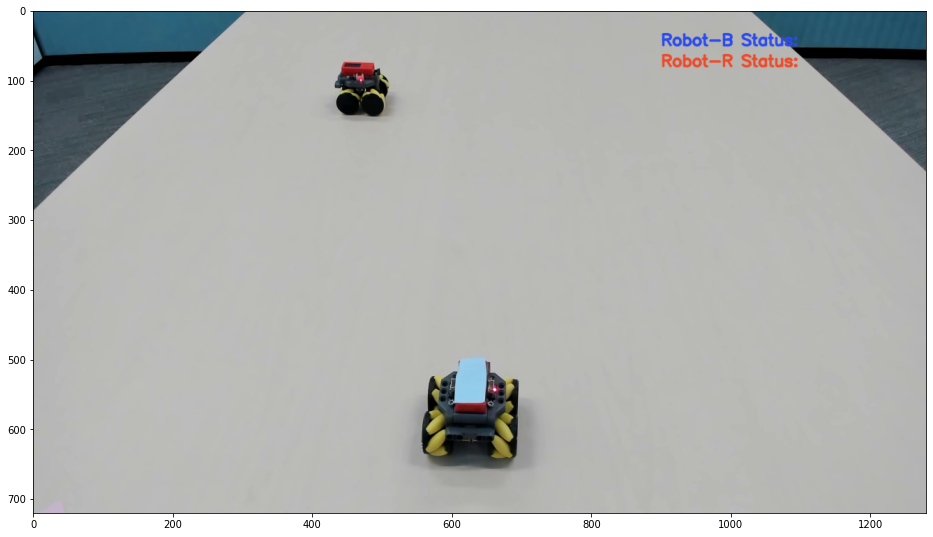

In [ ]:
frame = next(frame_iterator)
plot_image(frame, 16)

In [ ]:
import torch

model = torch.hub.load('./', 'custom', WEIGHTS_PATH,source='local', device=0)

## Install ByteTrack and other libs<a class="anchor" id="install-bytetrack"></a>

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
!cd ByteTrack && pip3 install -r requirements.txt
!cd ByteTrack && python3 setup.py develop
!pip install cython_bbox

In [ ]:
import sys
sys.path.append(f"{HOME}/ByteTrack")

In [ ]:
!pip install onemetric --quiet

In [ ]:
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch

## Custom annotator for robots <a class="anchor" id="custom-annotator"></a>

In [ ]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Tuple, Optional, List, Dict, Any

import cv2

import numpy as np


# geometry utilities


@dataclass(frozen=True)
class Point:
    x: float
    y: float
    
    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)


@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def min_x(self) -> float:
        return self.x
    
    @property
    def min_y(self) -> float:
        return self.y
    
    @property
    def max_x(self) -> float:
        return self.x + self.width
    
    @property
    def max_y(self) -> float:
        return self.y + self.height
        
    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)
    
    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)

    @property
    def top_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y)

    @property
    def center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height / 2)

    def pad(self, padding: float) -> Rect:
        return Rect(
            x=self.x - padding, 
            y=self.y - padding,
            width=self.width + 2*padding,
            height=self.height + 2*padding
        )
    
    def contains_point(self, point: Point) -> bool:
        return self.min_x < point.x < self.max_x and self.min_y < point.y < self.max_y


# detection utilities


@dataclass
class Detection:
    rect: Rect
    class_id: int
    class_name: str
    confidence: float
    tracker_id: Optional[int] = None

    @classmethod
    def from_results(cls, pred: np.ndarray, names: Dict[int, str]) -> List[Detection]:
        result = []
        for x_min, y_min, x_max, y_max, confidence, class_id in pred:
            class_id=int(class_id)
            result.append(Detection(
                rect=Rect(
                    x=float(x_min),
                    y=float(y_min),
                    width=float(x_max - x_min),
                    height=float(y_max - y_min)
                ),
                class_id=class_id,
                class_name=names[class_id],
                confidence=float(confidence)
            ))
        return result


def filter_detections_by_class(detections: List[Detection], class_name: str) -> List[Detection]:
    return [
        detection
        for detection 
        in detections
        if detection.class_name == class_name
    ]


# draw utilities


@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int
        
    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

    @classmethod
    def from_hex_string(cls, hex_string: str) -> Color:
        r, g, b = tuple(int(hex_string[1 + i:1 + i + 2], 16) for i in (0, 2, 4))
        return Color(r=r, g=g, b=b)


def draw_rect(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, thickness)
    return image


def draw_filled_rect(image: np.ndarray, rect: Rect, color: Color) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, -1)
    return image


def draw_polygon(image: np.ndarray, countour: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, thickness)
    return image


def draw_filled_polygon(image: np.ndarray, countour: np.ndarray, color: Color) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, -1)
    return image


def draw_text(image: np.ndarray, anchor: Point, text: str, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.putText(image, text, anchor.int_xy_tuple, cv2.FONT_HERSHEY_SIMPLEX, 0.7, color.bgr_tuple, thickness, 2, False)
    return image


def draw_ellipse(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.ellipse(
        image,
        center=rect.bottom_center.int_xy_tuple,
        axes=(int(rect.width), int(0.35 * rect.width)),
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color.bgr_tuple,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
    return image


# base annotator
  

@dataclass
class BaseAnnotator:
    colors: List[Color]
    thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            annotated_image = draw_ellipse(
                image=image,
                rect=detection.rect,
                color=self.colors[detection.class_id],
                thickness=self.thickness
            )
        return annotated_image

In [ ]:
# white
robot_blue_COLOR_HEX = "#797EF6"
robot_b_COLOR = Color.from_hex_string(robot_blue_COLOR_HEX)

# red
robot_r_COLOR_HEX = "#FF3131"
robot_r_COLOR = Color.from_hex_string(robot_r_COLOR_HEX)



COLORS = [
    robot_r_COLOR,
    robot_b_COLOR,
        
]
THICKNESS = 10

In [ ]:
# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

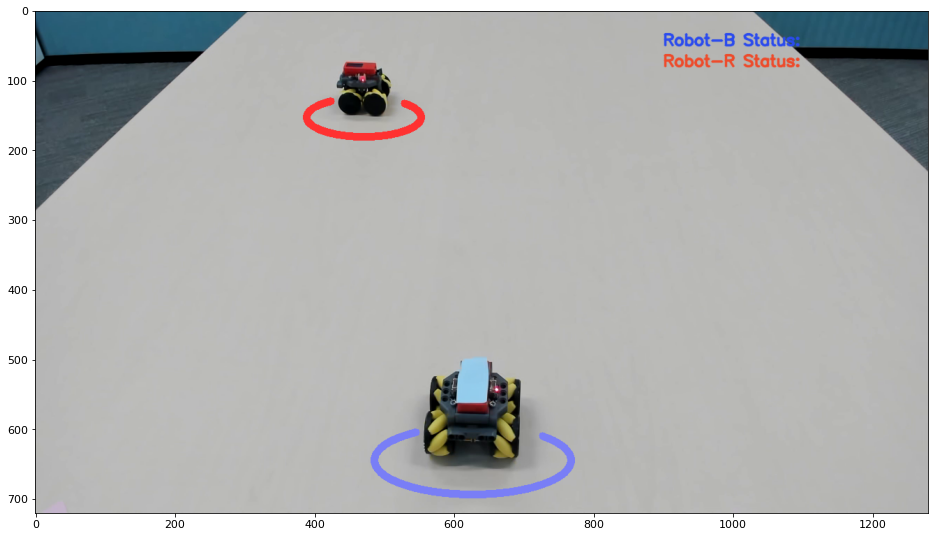

In [ ]:
# initiate annotators
annotator = BaseAnnotator(
    colors=COLORS, 
    thickness=THICKNESS)

# acquire video frame
frame = next(frame_iterator)
img = frame.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
img = np.ascontiguousarray(img)
# run detector
results = model(img, size=1280)
detections = Detection.from_results(
    pred=results.pred[0].cpu().numpy(), 
    names=model.names)

# annotate video frame
annotated_image = annotator.annotate(
    image=frame, 
    detections=detections)

# plot video frame
plot_image(annotated_image, 16)

In [ ]:
from dataclasses import dataclass

import cv2


"""
usage example:

video_config = VideoConfig(
    fps=30, 
    width=1920, 
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH, 
    video_config=video_config)

for frame in frames:
    ...
    video_writer.write(frame)
    
video_writer.release()
"""


# stores information about output video file, width and height of the frame must be equal to input video
@dataclass(frozen=True)
class VideoConfig:
    fps: float
    width: int
    height: int
        

# create cv2.VideoWriter object that we can use to save output video
def get_video_writer(target_video_path: str, video_config: VideoConfig) -> cv2.VideoWriter:
    video_target_dir = os.path.dirname(os.path.abspath(target_video_path))
    os.makedirs(video_target_dir, exist_ok=True)
    return cv2.VideoWriter(
        target_video_path, 
        fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
        fps=video_config.fps, 
        frameSize=(video_config.width, video_config.height), 
        isColor=True
    )

In [ ]:
from typing import List

import numpy as np

"""
BYTETracker does not assign tracker_id to existing bounding boxes but rather
predicts the next bounding box position based on previous one. Therefore, we 
need to find a way to match our bounding boxes with predictions.

usage example:

byte_tracker = BYTETracker(BYTETrackerArgs())
for frame in frames:
    ...
    results = model(frame, size=1280)
    detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(), 
        names=model.names)
    ...
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=detections),
        img_info=frame.shape,
        img_size=frame.shape)
    detections = match_detections_with_tracks(detections=detections, tracks=tracks)
"""

# converts List[Detection] into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: List[Detection], with_confidence: bool = True) -> np.ndarray:
    return np.array([
        [
            detection.rect.top_left.x, 
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y,
            detection.confidence
        ] if with_confidence else [
            detection.rect.top_left.x, 
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y
        ]
        for detection
        in detections
    ], dtype=float)


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: List[Detection], 
    tracks: List[STrack]
) -> List[Detection]:
    detection_boxes = detections2boxes(detections=detections, with_confidence=False)
    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detection_boxes)
    track2detection = np.argmax(iou, axis=1)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            detections[detection_index].tracker_id = tracks[tracker_index].track_id
    return detections

## Put everything together <a class="anchor" id="put-everything-together"></a>

Output of the algorithm is saved in the specified TARGET_VIDEO_PATH. Takes around 10 minutes to run this cell

In [ ]:

# settings
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/robot_demo/221207-robots-v2-5-7-min.mov"
TARGET_VIDEO_PATH = "/content/drive/MyDrive/robot_demo/output_th_1.mp4"

In [ ]:
from tqdm.notebook import tqdm

# initiate video writer
video_config = VideoConfig(
    fps=30, 
    width=1280, 
    height=720)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH, 
    video_config=video_config)

# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

# white
robot_blue_COLOR_HEX = "#797EF6"
robot_b_COLOR = Color.from_hex_string(robot_blue_COLOR_HEX)

# red
robot_r_COLOR_HEX = "#FF3131"
robot_r_COLOR = Color.from_hex_string(robot_r_COLOR_HEX)



COLORS = [
    robot_r_COLOR,
    robot_b_COLOR,
        
]
THICKNESS = 10
# initiate annotators
base_annotator = BaseAnnotator(
    colors=[
        robot_r_COLOR,
        robot_b_COLOR,
    ], 
    thickness=THICKNESS)

robot_r_text_annotator = TextAnnotator(
    robot_r_COLOR, text_color=Color(255, 255, 255), text_thickness=2)
robot_b_text_annotator = TextAnnotator(
    robot_b_COLOR, text_color=Color(0, 0, 0), text_thickness=2)

'''ball_marker_annotator = MarkerAnntator(
    color=BALL_MARKER_FILL_COLOR)
player_in_possession_marker_annotator = MarkerAnntator(
    color=PLAYER_MARKER_FILL_COLOR)'''


# initiate tracker
byte_tracker = BYTETracker(BYTETrackerArgs())

robot_b_history = []
robot_r_history = []
# loop over frames
def check_motion_simple(input_list):
  if len(input_list)>2:
    last_x,last_y= input_list[-1]
    last1_x,last1_y =input_list[-2]
    #print('last',last_x,last_y)
    #print('last1',last1_x,last1_y)
    diff_x = abs(last_x-last1_x)
    diff_y = abs(last_y-last1_y)
    diff_sum = diff_x+diff_y
    if diff_sum < 1:
      return('Stopped')
    else:
      return('Moving')
  else:
    return('Initialising')

  
for frame in tqdm(frame_iterator, total=750):

    # run detector
    img = frame.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img = np.ascontiguousarray(img)
    results = model(img, size=640)
    detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(), 
        names=model.names)
    
    # filter detections by class
    robot_r_detections = filter_detections_by_class(detections=detections, class_name="Robot-R")
    robot_b_detections = filter_detections_by_class(detections=detections, class_name="Robot-B")
    
    tracked_detections = robot_r_detections + robot_b_detections 

    

    # track
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=tracked_detections),
        img_info=frame.shape,
        img_size=frame.shape
    )
    tracked_detections = match_detections_with_tracks(detections=tracked_detections, tracks=tracks)

    tracked_robot_r_detections = filter_detections_by_class(detections=tracked_detections, class_name="Robot-R")
    tracked_robot_b_detections = filter_detections_by_class(detections=tracked_detections, class_name="Robot-B")
    #tracked_player_detections = filter_detections_by_class(detections=tracked_detections, class_name="player")
    try:
      
      left_x,left_y,right_x,right_y=detections2boxes(tracked_robot_r_detections, with_confidence= False)[0]
      robot_r_history.append([(right_x + right_y)/2,(left_x+left_y)/2])
      status_r = check_motion_simple(robot_r_history)
      
    except:
      status_r = 'Not in frame'
    try:
      left_x,left_y,right_x,right_y=detections2boxes(tracked_robot_b_detections, with_confidence= False)[0]
      robot_b_history.append([(right_x + right_y)/2,(left_x+left_y)/2])
      status_b = check_motion_simple(robot_b_history)
    except:
      status_b = 'Not in frame'

    # annotate video frame
    annotated_image = frame.copy()
    annotated_image = base_annotator.annotate(
        image=annotated_image, 
        detections=tracked_detections)
    import cv2
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    cv2.putText(annotated_image, 'Robot-B Status:' + status_b, (850,50), font, 0.75, (238, 75, 43), 2, cv2.LINE_AA)
    cv2.putText(annotated_image, 'Robot-R Status:'+ status_r, (850,80), font, 0.75, (43, 75, 238), 2, cv2.LINE_AA) 
      
    

    # save video frame
    video_writer.write(annotated_image)

# close output video
video_writer.release()